In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%matplotlib inline
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

os.chdir('/content/drive/My Drive/GitHub Repositories/Transfer Learning and Fine Tuning with Pre-Trained Networks')
trainDir = './datasets/x-rays/train'
validDir = './datasets/x-rays/test'

IMG_SIZE = 512 # slightly smaller than vgg16 normally expects
datagen = ImageDataGenerator(rescale=1./255, 
                             samplewise_center=False, 
                             samplewise_std_normalization=False, 
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.15, 
                             width_shift_range = 0.15, 
                             rotation_range = 5, 
                             shear_range = 0.01,
                             fill_mode = 'nearest',
                             zoom_range=0.1,  
                             )

train_gen = datagen.flow_from_directory(
    directory=trainDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=2019)

valid_gen = datagen.flow_from_directory(
    directory=validDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=2019)




Using TensorFlow backend.


Found 721 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


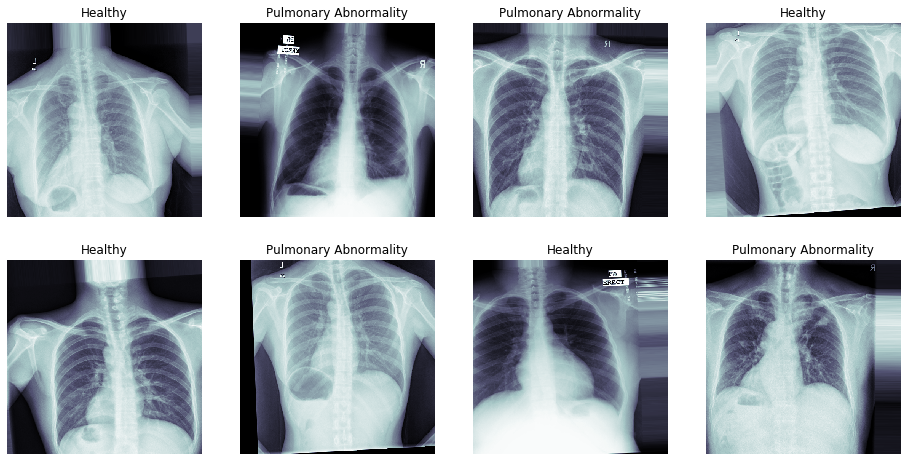

In [3]:
import matplotlib.pyplot as plt

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if np.argmax(c_y)>0.5 else 'Healthy'))
    c_ax.axis('off')


In [4]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import *

IMG_SIZE = 512
img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

vgg16_model = VGG16(input_shape =  img_shape, include_top = False, weights = 'imagenet')
vgg16_model.trainable = False
outputs = vgg16_model(inputs)
outputs = BatchNormalization(name = 'BatchNormalization')(outputs)
outputs = GlobalAveragePooling2D()(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(256)(outputs)
outputs = LeakyReLU(alpha=0.1)(outputs)
outputs = Dropout(0.25)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()





58892288/58889256 [==============================] - 5s 0us/step








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 16, 16, 512)       2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_______________________________________________________________

In [0]:
from keras.callbacks import *

weight_path=os.path.join( './saved models/VGG16 Model', '{}_pretrainedvgg16model.bestmodel.h5'.format('TB'))
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="'val_acc'", mode="auto", patience=30) 

callbacks_list = [checkpoint, early, reduceLROnPlat]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 3, callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '




Epoch 1/3


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/22 [=>............................] - ETA: 14:07 - loss: 0.7340 - acc: 0.3906

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/22 [===>..........................] - ETA: 13:32 - loss: 0.7150 - acc: 0.4375

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/22 [====>.........................] - ETA: 12:36 - loss: 0.6912 - acc: 0.4922

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/22 [=====>........................] - ETA: 12:08 - loss: 0.6739 - acc: 0.5375

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/22 [========>.....................] - ETA: 9:18 - loss: 0.6455 - acc: 0.5893 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/22 [=========>....................] - ETA: 8:47 - loss: 0.6310 - acc: 0.6133

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/22 [===========>..................] - ETA: 8:10 - loss: 0.6213 - acc: 0.6319

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/22 [============>.................] - ETA: 7:41 - loss: 0.6109 - acc: 0.6500

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/22 [==============>...............] - ETA: 7:01 - loss: 0.6041 - acc: 0.6591

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/22 [===============>..............] - ETA: 6:22 - loss: 0.6043 - acc: 0.6615

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/22 [================>.............] - ETA: 5:44 - loss: 0.5998 - acc: 0.6779

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/22 [==================>...........] - ETA: 5:05 - loss: 0.5813 - acc: 0.6920

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/22 [===================>..........] - ETA: 4:28 - loss: 0.5955 - acc: 0.6896

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/22 [======================>.......] - ETA: 3:08 - loss: 0.6001 - acc: 0.6937

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/22 [=======================>......] - ETA: 2:31 - loss: 0.6013 - acc: 0.6951

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/22 [========================>.....] - ETA: 1:54 - loss: 0.5948 - acc: 0.7012

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/22 [==========================>...] - ETA: 1:17 - loss: 0.5911 - acc: 0.7006

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/22 [===========================>..] - ETA: 38s - loss: 0.5853 - acc: 0.7074 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/22 [==============================] - 866s 39s/step - loss: 0.5835 - acc: 0.7092 - val_loss: 0.4774 - val_acc: 0.7812

Epoch 00001: val_acc improved from -inf to 0.78125, saving model to ./saved models/VGG16 Model/TB_pretrainedvgg16model.bestmodel.h5


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `'val_acc'` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/3


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/22 [>.............................] - ETA: 17:15 - loss: 0.3816 - acc: 0.8438